In [1]:
import sys
# from matplotlib import pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2023-07-05 15:59:10.321071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY, 10)
    testY = to_categorical(testY, 10)
    return trainX, trainY, testX, testY

# load dataset
trainX, trainY, testX, testY = load_dataset()

In [3]:
print(trainX.shape)
print(testX.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


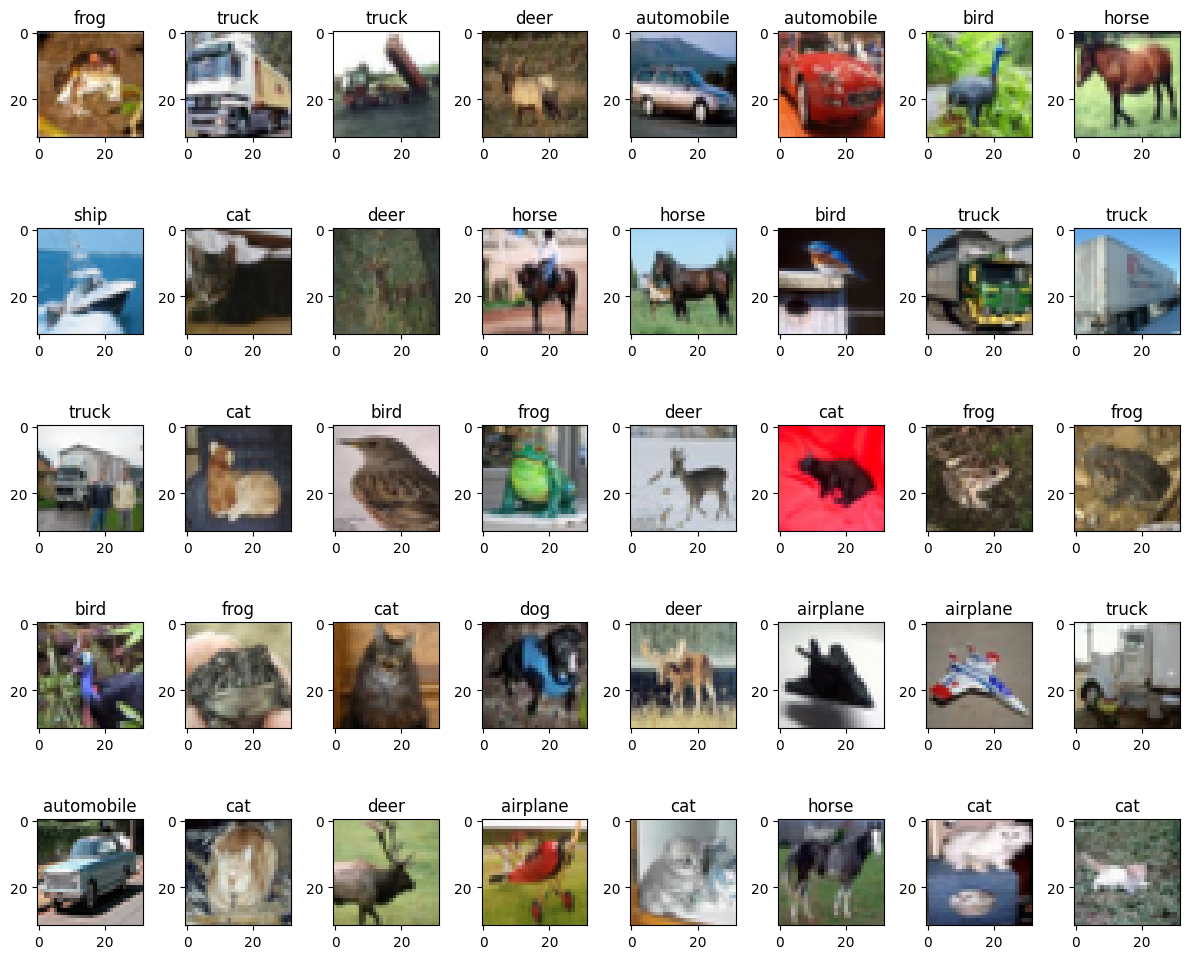

In [4]:
def plot_sample_images(trainX, trainY):
    Rename_labels = {0 : "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
          5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
    num_row = 5
    num_col = 8
    num = num_row * num_col
    sample_images = trainX[:num]
    sample_labels = trainY[:num]
    
    Rename_sample_labels = []
    
    #Rename the labels
    for i in range(len(sample_labels)):
        res = np.nonzero(sample_labels[i])[0]
        Rename_sample_labels.append(Rename_labels[res[0]])
    

    #plot images
    fig, axes = pyplot.subplots(num_row, num_col, figsize=(1.5*num_col, 2* num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col] #floored quotient of x and y, remainder of x / y
        ax.imshow(sample_images[i], cmap='gray')
        ax.set_title(Rename_sample_labels[i])
    pyplot.tight_layout()
    pyplot.savefig("Cifar_Sample")
    pyplot.show()
    

plot_sample_images(trainX, trainY)

In [5]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)
print(trainX.shape)
print(valX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
## define cnn model
# This cnn architecture refer to the link: 
# https://www.kaggle.com/code/kedarsai/cifar-10-88-accuracy-using-keras

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    # opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# define model
model = define_model()

2023-07-05 15:59:17.753790: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-05 15:59:17.754912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-05 15:59:17.779523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-07-05 15:59:17.779554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-05 15:59:17.812232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-05 15:59:17.812340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [7]:
##fit model
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("cifar10_model.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
history = model.fit(trainX, trainY, epochs=50, validation_data=(valX, valY), callbacks=[checkpoint, early],batch_size=32, verbose=1)

2023-07-05 15:59:19.296789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-05 15:59:19.311756: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz


Epoch 1/50


2023-07-05 15:59:19.987866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-07-05 15:59:20.310373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-07-05 15:59:21.337228: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-07-05 15:59:21.358288: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1250/1250 [==============================] - 12s 5ms/step - loss: 2.0597 - accuracy: 0.3258 - val_loss: 1.1638 - val_accuracy: 0.5806

Epoch 00001: val_accuracy improved from -inf to 0.58060, saving model to cifar10_model.h5
Epoch 2/50
1250/1250 [==============================] - 3s 3ms/step - loss: 1.2190 - accuracy: 0.5675 - val_loss: 0.9631 - val_accuracy: 0.6575

Epoch 00002: val_accuracy improved from 0.58060 to 0.65750, saving model to cifar10_model.h5
Epoch 3/50
1250/1250 [==============================] - 3s 3ms/step - loss: 0.9816 - accuracy: 0.6596 - val_loss: 0.8940 - val_accuracy: 0.6811

Epoch 00003: val_accuracy improved from 0.65750 to 0.68110, saving model to cifar10_model.h5
Epoch 4/50
1250/1250 [==============================] - 3s 3ms/step - loss: 0.8700 - accuracy: 0.7004 - val_loss: 0.7405 - val_accuracy: 0.7421

Epoch 00004: val_accuracy improved from 0.68110 to 0.74210, saving model to cifar10_model.h5
Epoch 5/50
1250/1250 [==============================] - 3s 3m

In [8]:
model.save("cifar_model.h5")

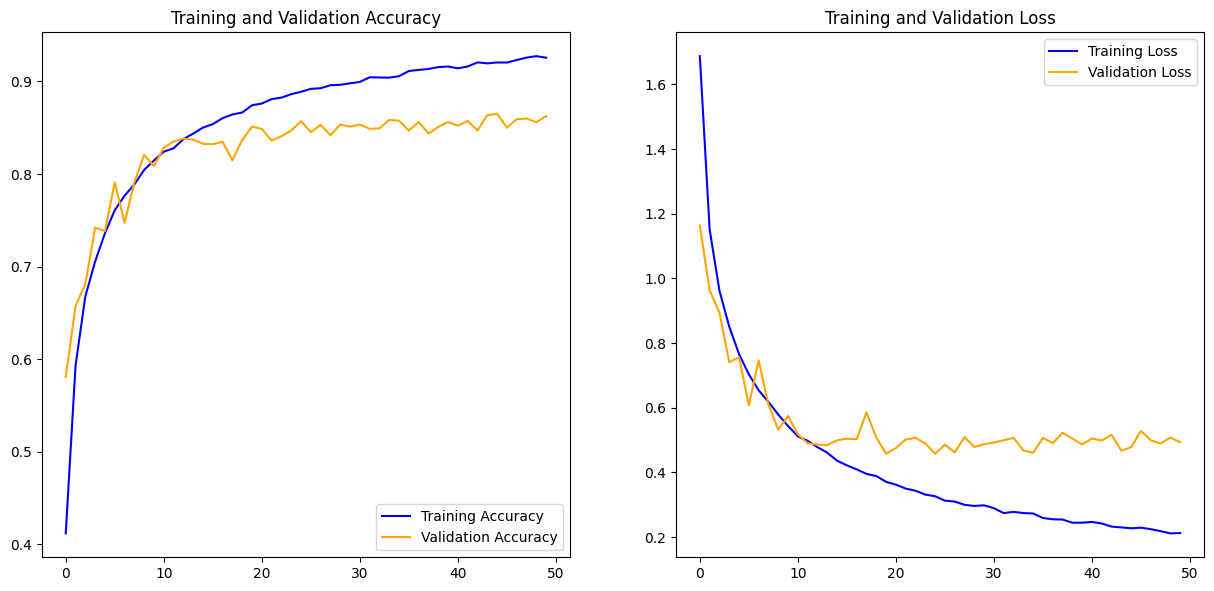

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


pyplot.figure(figsize=(15, 15))
pyplot.subplot(2, 2, 1)
pyplot.plot(acc, color="blue", label='Training Accuracy')
pyplot.plot(val_acc, color="orange", label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(2, 2, 2)
pyplot.plot(loss, color="blue", label='Training Loss')
pyplot.plot(val_loss, color="orange", label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.savefig("Cifar10_6conv.png")
pyplot.show()

In [10]:
##evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print(acc)
_, acc = model.evaluate(trainX, trainY, verbose=0)
print(acc)
_,acc = model.evaluate(valX, valY, verbose=0)
print(acc)

0.8610000014305115
0.9903249740600586
0.862500011920929


In [11]:
# The second-stage training
model1 = load_model("cifar10_model.h5")
model1_first_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_first_layer_output_train = model1_first_layer_output.predict(trainX, batch_size=32)
model1_first_layer_output_val = model1_first_layer_output.predict(valX, batch_size=32)
model1_first_layer_output_test = model1_first_layer_output.predict(testX, batch_size=32)


model2 = Sequential()
# model2.add(Dense(512,activation="relu"))
model2.add(Dense(10, activation='softmax'))
    # compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("cifar10_25_model2.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')


model2.fit(model1_first_layer_output_train, trainY, epochs=50, validation_data=(model1_first_layer_output_val, valY), callbacks=[checkpoint, early], batch_size=32)


_,acc = model2.evaluate(model1_first_layer_output_test, testY, verbose=0)
print(acc)
_,acc = model2.evaluate(model1_first_layer_output_train, trainY, verbose=0)
print(acc)
_,acc = model2.evaluate(model1_first_layer_output_val, valY, verbose=0)
print(acc)


del model1_first_layer_output_train
del model1_first_layer_output_val
del model1_first_layer_output_test
del model1, model2
tf.keras.backend.clear_session()

Epoch 1/50
1250/1250 [==============================] - 1s 726us/step - loss: 0.4759 - accuracy: 0.8799 - val_loss: 0.4632 - val_accuracy: 0.8633

Epoch 00001: val_accuracy improved from -inf to 0.86330, saving model to cifar10_25_model2.h5
Epoch 2/50
1250/1250 [==============================] - 1s 676us/step - loss: 0.0440 - accuracy: 0.9893 - val_loss: 0.5232 - val_accuracy: 0.8633

Epoch 00002: val_accuracy did not improve from 0.86330
Epoch 3/50
1250/1250 [==============================] - 1s 704us/step - loss: 0.0297 - accuracy: 0.9914 - val_loss: 0.5689 - val_accuracy: 0.8642

Epoch 00003: val_accuracy improved from 0.86330 to 0.86420, saving model to cifar10_25_model2.h5
Epoch 4/50
1250/1250 [==============================] - 1s 677us/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.6086 - val_accuracy: 0.8631

Epoch 00004: val_accuracy did not improve from 0.86420
Epoch 5/50
1250/1250 [==============================] - 1s 685us/step - loss: 0.0245 - accuracy: 0.9919 - val_l

In [12]:
model1 = load_model("cifar10_model.h5")
model1_first_layer_output = Model(inputs=model1.input, outputs=model1.layers[-2].output)
model1_first_layer_output_train = model1_first_layer_output.predict(trainX, batch_size=32)
model1_first_layer_output_val = model1_first_layer_output.predict(valX, batch_size=32)
model1_first_layer_output_test = model1_first_layer_output.predict(testX, batch_size=32)


model2 = Sequential()
# model2.add(Dense(512,activation="relu"))
model2.add(Dense(10, activation='softmax'))
    # compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("cifar10_25_model3.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')

model2.fit(model1_first_layer_output_train, trainY, epochs=25, validation_data=(model1_first_layer_output_val, valY), callbacks=[checkpoint, early], batch_size=32)


_,acc = model2.evaluate(model1_first_layer_output_test, testY, verbose=0)
print(acc)
_,acc = model2.evaluate(model1_first_layer_output_train, trainY, verbose=0)
print(acc)
_,acc = model2.evaluate(model1_first_layer_output_val, valY, verbose=0)
print(acc)


del model1_first_layer_output_train
del model1_first_layer_output_val
del model1_first_layer_output_test
del model1, model2
tf.keras.backend.clear_session()

Epoch 1/25
1250/1250 [==============================] - 1s 717us/step - loss: 0.6880 - accuracy: 0.8589 - val_loss: 0.4408 - val_accuracy: 0.8597

Epoch 00001: val_accuracy improved from -inf to 0.85970, saving model to cifar10_25_model3.h5
Epoch 2/25
1250/1250 [==============================] - 1s 681us/step - loss: 0.1030 - accuracy: 0.9882 - val_loss: 0.4348 - val_accuracy: 0.8612

Epoch 00002: val_accuracy improved from 0.85970 to 0.86120, saving model to cifar10_25_model3.h5
Epoch 3/25
1250/1250 [==============================] - 1s 694us/step - loss: 0.0744 - accuracy: 0.9900 - val_loss: 0.4402 - val_accuracy: 0.8612

Epoch 00003: val_accuracy did not improve from 0.86120
Epoch 4/25
1250/1250 [==============================] - 1s 705us/step - loss: 0.0618 - accuracy: 0.9902 - val_loss: 0.4469 - val_accuracy: 0.8622

Epoch 00004: val_accuracy improved from 0.86120 to 0.86220, saving model to cifar10_25_model3.h5
Epoch 5/25
1250/1250 [==============================] - 1s 703us/step